In [1]:
%matplotlib inline


# Precision-Recall


Example of Precision-Recall metric to evaluate classifier output quality.

Precision-Recall is a useful measure of success of prediction when the
classes are very imbalanced. In information retrieval, precision is a
measure of result relevancy, while recall is a measure of how many truly
relevant results are returned.

The precision-recall curve shows the tradeoff between precision and
recall for different threshold. A high area under the curve represents
both high recall and high precision, where high precision relates to a
low false positive rate, and high recall relates to a low false negative
rate. High scores for both show that the classifier is returning accurate
results (high precision), as well as returning a majority of all positive
results (high recall).

A system with high recall but low precision returns many results, but most of
its predicted labels are incorrect when compared to the training labels. A
system with high precision but low recall is just the opposite, returning very
few results, but most of its predicted labels are correct when compared to the
training labels. An ideal system with high precision and high recall will
return many results, with all results labeled correctly.

Precision ($P$) is defined as the number of true positives ($T_p$)
over the number of true positives plus the number of false positives
($F_p$).

$P = \frac{T_p}{T_p+F_p}$

Recall ($R$) is defined as the number of true positives ($T_p$)
over the number of true positives plus the number of false negatives
($F_n$).

$R = \frac{T_p}{T_p + F_n}$

These quantities are also related to the ($F_1$) score, which is defined
as the harmonic mean of precision and recall.

$F1 = 2\frac{P \times R}{P+R}$

Note that the precision may not decrease with recall. The
definition of precision ($\frac{T_p}{T_p + F_p}$) shows that lowering
the threshold of a classifier may increase the denominator, by increasing the
number of results returned. If the threshold was previously set too high, the
new results may all be true positives, which will increase precision. If the
previous threshold was about right or too low, further lowering the threshold
will introduce false positives, decreasing precision.

Recall is defined as $\frac{T_p}{T_p+F_n}$, where $T_p+F_n$ does
not depend on the classifier threshold. This means that lowering the classifier
threshold may increase recall, by increasing the number of true positive
results. It is also possible that lowering the threshold may leave recall
unchanged, while the precision fluctuates.

The relationship between recall and precision can be observed in the
stairstep area of the plot - at the edges of these steps a small change
in the threshold considerably reduces precision, with only a minor gain in
recall.

**Average precision** (AP) summarizes such a plot as the weighted mean of
precisions achieved at each threshold, with the increase in recall from the
previous threshold used as the weight:

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

where $P_n$ and $R_n$ are the precision and recall at the
nth threshold. A pair $(R_k, P_k)$ is referred to as an
*operating point*.

AP and the trapezoidal area under the operating points
(:func:`sklearn.metrics.auc`) are common ways to summarize a precision-recall
curve that lead to different results. Read more in the
`User Guide <precision_recall_f_measure_metrics>`.

Precision-recall curves are typically used in binary classification to study
the output of a classifier. In order to extend the precision-recall curve and
average precision to multi-class or multi-label classification, it is necessary
to binarize the output. One curve can be drawn per label, but one can also draw
a precision-recall curve by considering each element of the label indicator
matrix as a binary prediction (micro-averaging).

<div class="alert alert-info"><h4>Note</h4><p>See also :func:`sklearn.metrics.average_precision_score`,
             :func:`sklearn.metrics.recall_score`,
             :func:`sklearn.metrics.precision_score`,
             :func:`sklearn.metrics.f1_score`</p></div>



In [2]:
from __future__ import print_function

In binary classification settings
--------------------------------------------------------

Create simple data
..................

Try to differentiate the two first classes of the iris data



In [3]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

Compute the average precision score
...................................



In [4]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.88


Plot the Precision-Recall curve
................................



Text(0.5,1,'2-class Precision-Recall curve: AP=0.88')

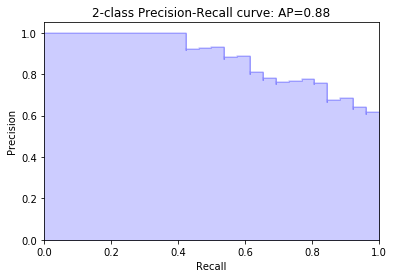

In [5]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In multi-label settings
------------------------

Create multi-label data, fit, and predict
...........................................

We create a multi-label dataset, to illustrate the precision-recall in
multi-label settings



In [6]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=random_state)

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

The average precision score in multi-label settings
....................................................



In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.43


Plot the micro-averaged Precision-Recall curve
...............................................




Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.43')

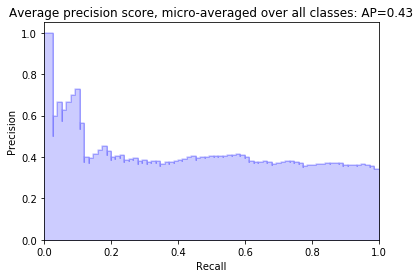

In [8]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

Plot Precision-Recall curve for each class and iso-f1 curves
.............................................................




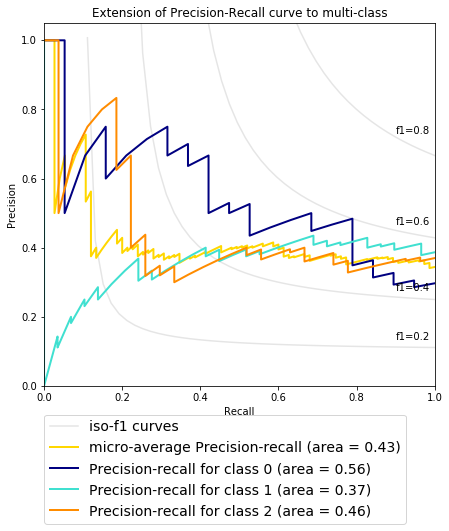

In [9]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()